In [1]:
%load_ext autoreload
%autoreload 2


import sspspace
import numpy as np
import pandas as pd
import nengo
import scipy.special
import matplotlib.pyplot as plt
from scipy.stats import beta, norm

from nengo.config import Config
from nengo.ensemble import Ensemble
import nengo_dft
from dnf import DNF_BG_DYNDA
from utils import *

from nengo_extras.plot_spikes import (
    cluster,
    merge,
    plot_spikes,
    preprocess_spikes,
    sample_by_variance,
)

In [2]:
## create SSP encoder and neuron encoders

## set action space domain
domain = np.arange(0,4,0.01).reshape((-1,1))
ssp_dim = 64
## create SSP encoder
ssp_encoder = sspspace.RandomSSPSpace(domain_dim=1, ssp_dim=ssp_dim, 
                                      rng=np.random.RandomState(), 
                                      length_scale=0.5)
## encode domain as SSPs
domain_phis = ssp_encoder.encode(domain)

## Encoders
low = 0
high = 4
width = high - low
places_ = np.arange(low, high, width/400)
encoders = np.asarray(ssp_encoder.encode(places_.reshape(-1,1))).squeeze()

Entropy ignoring 0's, H: 6.456295301278954


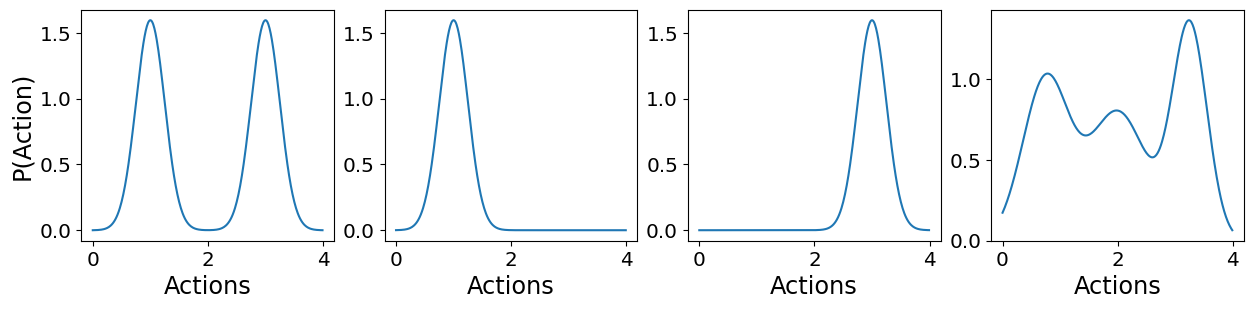

In [3]:
## generate two gaussian curves
mean1 = 1
sigma1 = 0.25
mean2 = 3
sigma2 = 0.25
Ps1 = norm.pdf(domain, mean1, sigma1)
Ps2 = norm.pdf(domain, mean2, sigma2)

mean_mess1 = 0.75
sigma_mess1 = 0.4
mean_mess2 = 3.25
sigma_mess2 = 0.3
mean_mess3 = 2
sigma_mess3 = 0.5
mess1 = norm.pdf(domain, mean_mess1, sigma_mess1)
mess2 = norm.pdf(domain, mean_mess2, sigma_mess2)
mess3 = norm.pdf(domain, mean_mess3, sigma_mess3)

## add them together to make a bimodal distribution
bimod_Ps = Ps1 + Ps2
messy_Ps = mess1 + mess2 + mess3
print(f"Entropy ignoring 0's, H: {entropy(bimod_Ps[bimod_Ps != 0])}")
## encode as an SSP bundle
bimod_pattern = gen_beta_cont_dist(bimod_Ps.squeeze(), domain_phis)
left_pattern = gen_beta_cont_dist(Ps1.squeeze(), domain_phis)
right_pattern = gen_beta_cont_dist(Ps2.squeeze(), domain_phis)
mid_pattern = gen_beta_cont_dist(messy_Ps.squeeze(), domain_phis)

multi_patterns = [bimod_pattern, left_pattern, mid_pattern, right_pattern]

plt.figure(figsize=(15,3))

plt.subplot(141)
plt.plot(domain, bimod_Ps)
plt.xlabel("Actions", fontsize="xx-large")
plt.ylabel("P(Action)", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")
plt.subplot(142)
plt.plot(domain, Ps1)
plt.xlabel("Actions", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")
plt.subplot(143)
plt.plot(domain, Ps2)
plt.xlabel("Actions", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")
plt.subplot(144)
plt.plot(domain, messy_Ps)
plt.xlabel("Actions", fontsize="xx-large")
plt.tick_params("both", labelsize="x-large")

In [4]:
#Look at the vectors:
print(f"beta distribution vector: {bimod_pattern[:5]}")
print()
print(f"left leaning distribution vector: {left_pattern[:5]}")
print()
print(f"centered distribution vector: {mid_pattern[:5]}")
print()
print(f"right leaning distribution vector: {right_pattern[:5]}")

beta distribution vector: [31.65015979 -3.55288449 13.54871371 -2.92078321 15.86117987]

left leaning distribution vector: [18.75543684  6.95639456  0.03004393 -9.93622596 12.13655244]

centered distribution vector: [ 45.67598109  11.05502076   7.69823182 -10.77523156   8.77657164]

right leaning distribution vector: [ 12.89472295 -10.50927905  13.51866978   7.01544276   3.72462743]


## Just an Ensemble

In [5]:
def run_net_simple(stim):
    ## Create nengo model
    model = nengo.Network()
    with model:
        
        inp_node = nengo.Node(nengo.processes.PresentInput(stim, presentation_time=0.5))

        ens = nengo.Ensemble(n_neurons=100,
                             dimensions=ssp_dim, 
                             encoders=nengo.Default,
                             radius=1.0,
                             neuron_type=nengo.LIF(),
                             )

        out_node = nengo.Node(size_in = ssp_dim)

        nengo.Connection(inp_node, ens, synapse=None)
        nengo.Connection(ens, out_node, synapse=None)

        p_in = nengo.Probe(inp_node, synapse=None)
        p_out = nengo.Probe(out_node, synapse=None)
        p_neurons = nengo.Probe(ens.neurons)
        p_ens = nengo.Probe(ens)

    with nengo.Simulator(model) as sim:
        sim.run(2.0)

    return sim.data[p_in], sim.data[p_out], sim.data[p_neurons], sim.data[p_ens]

In [6]:
da_inp, da_out, neurons, ens = run_net_simple(multi_patterns)

Build finished in 0:00:01.                                                      


c:\Users\maddy\anaconda3\envs\bgdlenv\lib\site-packages\nengo\cache.py:617: UserWarning: Decoder cache could not acquire lock and was deactivated.
  warnings.warn("Decoder cache could not acquire lock and was deactivated.")


Simulation finished in 0:00:01.                                                 


In [7]:
clustered_spikes = merge(*cluster(*sample_by_variance(np.arange(2000), neurons, num=100, filter_width=0.02), filter_width=0.02), num=100)

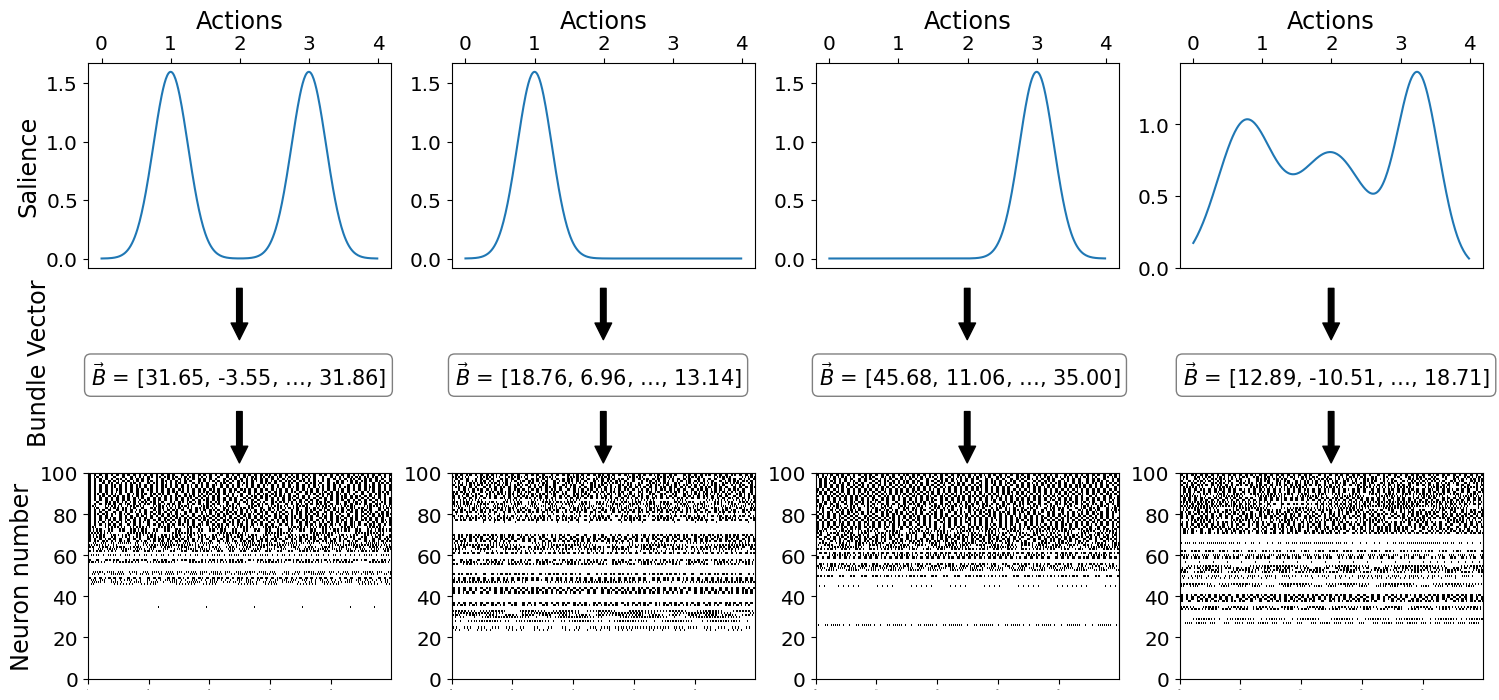

In [8]:
plt.figure(figsize=(18, 8))

ax1 = plt.subplot(2,4,1)
ax1.plot(domain, bimod_Ps)
ax1.set_xlabel("Actions", fontsize="xx-large")
ax1.xaxis.set_label_position('top') 
ax1.set_ylabel("Salience", fontsize="xx-large")
ax1.tick_params("both", labelsize="x-large", top=True, labeltop=True, bottom=False, labelbottom=False)
# ax1.set_ylim(-0.2, 1.05)

textstr = f"$\\vec{'B'}$ = [{bimod_pattern[0]:.2f}, {bimod_pattern[1]:.2f}, $\ldots$, {bimod_pattern[-1]:.2f}]"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.01, -0.45, textstr, transform=ax1.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
ax1.annotate('', xy=(0.5, -0.35), xycoords='axes fraction', xytext=(0.5,-0.1), 
            arrowprops=dict(color='black'))
ax1.annotate('', xy=(0.5, -0.95), xycoords='axes fraction', xytext=(0.5,-0.7), 
            arrowprops=dict(color='black'))

ax5 = plt.subplot(2,4,5)
plot_spikes(clustered_spikes[0][:500], clustered_spikes[1][:500])
ax5.set_ylabel("Neuron number", fontsize="xx-large")
ax5.tick_params("y", labelsize="x-large")
ax5.tick_params("x", labelsize=0)

ax2 = plt.subplot(2,4,2)
ax2.plot(domain, Ps1)
ax2.set_xlabel("Actions", fontsize="xx-large")
ax2.xaxis.set_label_position('top') 
ax2.tick_params("both", labelsize="x-large", top=True, labeltop=True, bottom=False, labelbottom=False)
# ax2.set_ylim(-0.2, 1.05)

textstr = f"$\\vec{'B'}$ = [{left_pattern[0]:.2f}, {left_pattern[1]:.2f}, $\ldots$, {left_pattern[-1]:.2f}]"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax2.text(0.01, -0.45, textstr, transform=ax2.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
ax2.annotate('', xy=(0.5, -0.35), xycoords='axes fraction', xytext=(0.5,-0.1), 
            arrowprops=dict(color='black'))
ax2.annotate('', xy=(0.5, -0.95), xycoords='axes fraction', xytext=(0.5,-0.7), 
            arrowprops=dict(color='black'))

ax6 = plt.subplot(2,4,6)
plot_spikes(clustered_spikes[0][500:1000], clustered_spikes[1][500:1000])
ax6.tick_params("y", labelsize="x-large")
ax6.tick_params("x", labelsize=0)

ax3 = plt.subplot(2,4,3)
ax3.plot(domain, Ps2)
ax3.set_xlabel("Actions", fontsize="xx-large")
ax3.xaxis.set_label_position('top') 
ax3.tick_params("both", labelsize="x-large", top=True, labeltop=True, bottom=False, labelbottom=False)
# ax3.set_ylim(-0.2, 1.05)

textstr = f"$\\vec{'B'}$ = [{mid_pattern[0]:.2f}, {mid_pattern[1]:.2f}, $\ldots$, {mid_pattern[-1]:.2f}]"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax3.text(0.01, -0.45, textstr, transform=ax3.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
ax3.annotate('', xy=(0.5, -0.35), xycoords='axes fraction', xytext=(0.5,-0.1), 
            arrowprops=dict(color='black'))
ax3.annotate('', xy=(0.5, -0.95), xycoords='axes fraction', xytext=(0.5,-0.7), 
            arrowprops=dict(color='black'))

ax7 = plt.subplot(2,4,7)
plot_spikes(clustered_spikes[0][1000:1500], clustered_spikes[1][1000:1500])
ax7.tick_params("y", labelsize="x-large")
ax7.tick_params("x", labelsize=0)

ax4 = plt.subplot(2,4,4)
ax4.plot(domain, messy_Ps)
ax4.set_xlabel("Actions", fontsize="xx-large")
ax4.xaxis.set_label_position('top') 
ax4.tick_params("both", labelsize="x-large", top=True, labeltop=True, bottom=False, labelbottom=False)
# ax4.set_ylim(-0.2, 1.05)

textstr = f"$\\vec{'B'}$ = [{right_pattern[0]:.2f}, {right_pattern[1]:.2f}, $\ldots$, {right_pattern[-1]:.2f}]"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax4.text(0.01, -0.45, textstr, transform=ax4.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
ax4.annotate('', xy=(0.5, -0.35), xycoords='axes fraction', xytext=(0.5,-0.1), 
            arrowprops=dict(color='black'))
ax4.annotate('', xy=(0.5, -0.95), xycoords='axes fraction', xytext=(0.5,-0.7), 
            arrowprops=dict(color='black'))

ax8 = plt.subplot(2,4,8)
plot_spikes(clustered_spikes[0][1500:2000], clustered_spikes[1][1500:2000])
ax8.tick_params("y", labelsize="x-large")
ax8.tick_params("x", labelsize=0)

# plt.tight_layout()
plt.subplots_adjust(hspace=1.0)

ax1.text(-0.2, -0.05, 'Bundle Vector', transform=ax1.transAxes, fontsize='xx-large',
        verticalalignment='top', rotation=90)

plt.savefig('figs/vecToSpike.pdf', bbox_inches="tight")